# Allen Cahn Equation

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import time

torch.set_default_dtype(torch.float64)

In [49]:
def sample_points(N_pts):
    
    # interior points
    N_domain_tot = N_pts**2
    x_int_train = torch.rand(N_domain_tot, 1, requires_grad=True)
    y_int_train = torch.rand(N_domain_tot, 1, requires_grad=True)
    
    # boundary
    # bottom points
    x_bottom = torch.rand(N_pts+1, 1)
    y_bottom = torch.zeros(N_pts+1, 1)
    # top points
    x_top = torch.rand(N_pts+1, 1)
    y_top = torch.ones(N_pts+1,1)
    # concatenate
    x_bound_train = torch.concat((x_bottom, x_top))
    y_bound_train = torch.concat((y_bottom, y_top))
    # left points
    x_left = torch.zeros(N_pts+1,1)
    y_left = torch.rand(N_pts+1,1)
    # concat
    x_bound_train = torch.concat((x_bound_train, x_left))
    y_bound_train = torch.concat((y_bound_train, y_left))
    # right points
    x_right = torch.ones(N_pts+1,1)
    y_right = torch.rand(N_pts+1,1)
    # concat
    x_bound_train = torch.concat((x_bound_train, x_right))
    y_bound_train = torch.concat((y_bound_train, y_right))
    
    return x_int_train, y_int_train, x_bound_train, y_bound_train



def u_true(a, x, y):
    return torch.sin(2* torch.pi * a * x) * torch.sin(2 * torch.pi * a * y)

def f(a, x, y):
    
    u = u_true(a, x,y)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    
    return u_xx + u_yy + u**3 - u

def g(a, x,y):
    return u_true(a, x,y)

In [50]:
class Allen_RF(nn.Module):
    """
    Random feature model
    """    
    def __init__(self, in_features, out_features, sigma=1.0):
        super(Allen_RF, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.sigma = sigma
        self.W = nn.Parameter(torch.randn(in_features, out_features) / sigma, requires_grad=False)
        self.b = nn.Parameter(torch.rand(out_features) * 2 * torch.pi, requires_grad=False)
        
        self.model = nn.Sequential(nn.Linear(out_features, 1))

        
    def forward(self,x,y):
        
        inputs = torch.cat((x,y), dim=1)
        u = self.model(torch.cos(inputs @ self.W + self.b) * torch.sqrt( torch.tensor([2 / self.out_features])))
        return u
    
class Allen_PINN(nn.Module):
    """
    Physic informed neural network for Allen-Cahn equation.
    """
    def __init__(self):
        super(Allen_PINN, self).__init__()
        self.model = nn.Sequential(
        nn.Linear(2,64),
        nn.Tanh(),
        nn.Linear(64,64),
        nn.Tanh(),
        nn.Linear(64,1))
        
    def forward(self,x,y):
        
        inputs = torch.cat((x,y), dim=1)
        u = self.model(inputs)
        return u    
    
def loss_fn(model, x_int, y_int, x_bound, y_bound, RHS, g, a):
    """
    Compute the loss
    """
    
    # interior:
    u = model(x_int,y_int)
    u_x = torch.autograd.grad(u, x_int, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_int, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y_int, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y_int, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    
    f = RHS(a, x_int,y_int)
    
    residual = u_xx + u_yy + u**3 - u - f
    
    # boundary
    residual_bound = model(x_bound, y_bound) - g(a, x_bound, y_bound)

    return torch.mean(residual**2) + torch.tensor([1e6]) * torch.mean(residual_bound**2)

def train(model, optimizer, x_int, y_int, x_bound, y_bound, RHS, g, a, epochs=1000):
    """
    Train networks
    """
    losses = []
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        loss = loss_fn(model, x_int, y_int, x_bound, y_bound, RHS, g, a)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    return losses

In [51]:
class Allen_ELM(nn.Module):
    """
    Extreme Learning Machine.
    """
    
    def __init__(self, in_features, out_features, R):
        super(Allen_ELM, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.R = R
        self.W = nn.Parameter(torch.rand(in_features, out_features) * 2 * R - R , requires_grad=False)
        
        self.model = nn.Sequential(nn.Linear(out_features, 1))
    
    def forward(self,x,y):
        
        inputs = torch.cat((x,y), dim=1)
        u = self.model(torch.tanh(inputs @ self.W))
        return u

## Case 1: a=10

In [53]:
# 
torch.manual_seed(5)
a = 10
# generate training samples
N_pts = 30
x_int_train, y_int_train, x_bound_train, y_bound_train = sample_points(N_pts)

# generate test samples
num_pts = 100
xx= np.linspace(0, 1, num_pts)
yy = np.linspace(0, 1, num_pts)
XX, YY = np.meshgrid(xx, yy)
XX_test, YY_test = XX.reshape(num_pts**2,1), YY.reshape(num_pts**2,1)
XX_test, YY_test = torch.from_numpy(XX_test), torch.from_numpy(YY_test)
XX, YY = torch.from_numpy(XX), torch.from_numpy(YY)
u_test = u_true(a,XX,YY)

# initialize model and optimizer
N = 200
model_RF = Allen_RF(2, N, sigma = 0.01)
optimizer = optim.Adam(model_RF.parameters(), lr=1e-2, weight_decay=0.001)

# Train the model
start = time.time()
losses = train(model_RF, optimizer, x_int_train,y_int_train, x_bound_train, y_bound_train, f, g, a, epochs=1000)
end = time.time()
print(f'Computational time is {end-start:.2f} seconds')

# compute test errors
RF_pred = model_RF(XX_test, YY_test)
RF_pred = RF_pred.detach().numpy()
RF_pred = RF_pred.reshape(num_pts,num_pts)
RF_err = np.sum( (u_test.detach().numpy() - RF_pred)**2 ) / np.size(RF_pred)
print(f'Test error of RF is {RF_err:.2e}')

Epoch 0, Loss: 16894612.42420945
Epoch 500, Loss: 12805812.313388906
Computational time is 20.04 seconds
Test error of RF is 3.92e-01


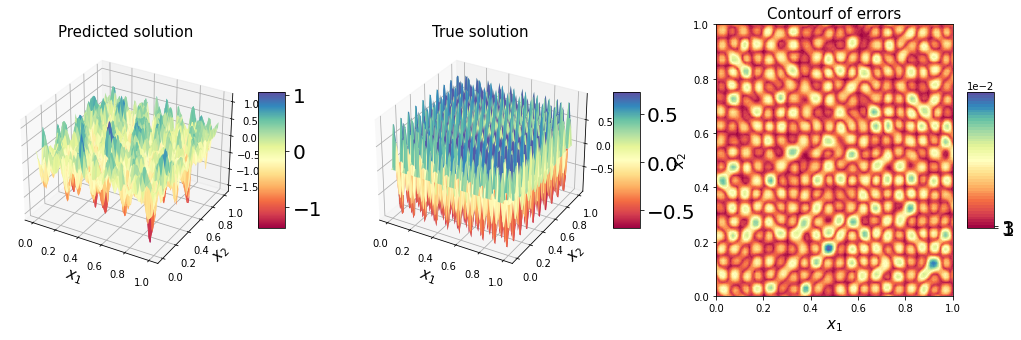

In [54]:
################### Visualization
fig = plt.figure(figsize=(18,5))

# plot the true solution
ax = fig.add_subplot(132, projection='3d')
u_truth_surf=ax.plot_surface(XX, YY, u_test, cmap='Spectral')
plt.xlabel(r'$x_1$', size=15) 
plt.ylabel(r'$x_2$', size=15)
plt.title('True solution', size=15)
cbar = fig.colorbar(u_truth_surf, shrink= 0.5, aspect = 5)
cbar.ax.tick_params(labelsize=20)

# plot the predicted solution
ax = fig.add_subplot(131, projection='3d')
u_test_surf=ax.plot_surface(XX, YY, RF_pred, cmap='Spectral')
plt.xlabel(r'$x_1$', size=15) 
plt.ylabel(r'$x_2$', size=15)
plt.title('Predicted solution', size=15)
cbar = fig.colorbar(u_test_surf, shrink= 0.5, aspect = 5)
cbar.ax.tick_params(labelsize=20)

# plot error
ax = fig.add_subplot(133)
u_contourf=ax.contourf(XX, YY, abs(u_test-RF_pred), 50, cmap='Spectral')
plt.xlabel(r'$x_1$', fontsize=15); 
plt.ylabel(r'$x_2$', fontsize=15); 
plt.title('Contourf of errors',size=15)
cbar = fig.colorbar(u_contourf, shrink= 0.5, aspect = 5, ticks=[0.01,0.03])
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.tick_params(labelsize=20)
plt.savefig('Allen-Cahn.pdf', bbox_inches = 'tight')

In [55]:
# initialize model and optimizer
model_PINN = Allen_PINN()
optimizer = optim.Adam(model_PINN.parameters(), lr=1e-2)

# Train the model
start = time.time()
losses = train(model_PINN, optimizer, x_int_train,y_int_train, x_bound_train, y_bound_train, f, g, a, epochs=2000)
end = time.time()
print(f'Computational time is {end-start:.2f} seconds')

# compute predictions and test error
PINN_pred = model_PINN(XX_test, YY_test)
PINN_pred = PINN_pred.detach().numpy()
PINN_pred = PINN_pred.reshape(num_pts,num_pts)
PINN_err = np.sum( (u_test.detach().numpy() - PINN_pred)**2 ) / np.size(PINN_pred)
print(f'Test error of PINN is {PINN_err:.2e}')


Epoch 0, Loss: 15941170.990691066
Epoch 500, Loss: 15874807.780744204
Epoch 1000, Loss: 15874721.47178298
Epoch 1500, Loss: 14933289.925059231
Computational time is 30.34 seconds
Test error of PINN is 1.59e+01


In [56]:
################### ELM
# initialize ELM model and optimizer
model_ELM = Allen_ELM(2, N, R = 0.05)
optimizer = optim.Adam(model_ELM.parameters(), lr=1e-2)


# Train the model
start = time.time()
losses = train(model_ELM, optimizer,x_int_train,y_int_train, x_bound_train, y_bound_train,f, g, a, epochs=1000)
end = time.time()
print(f'Computational time is {end-start:.2f} seconds')

# compute predictions and test error
ELM_pred = model_ELM(XX_test, YY_test)
ELM_pred = ELM_pred.detach().numpy()
ELM_pred = ELM_pred.reshape(num_pts,num_pts)
ELM_err = np.sum( (u_test.detach().numpy() - ELM_pred)**2 ) / np.size(ELM_pred)
print(f'Test error of ELM is {ELM_err:.2e}')

Epoch 0, Loss: 15875484.06584368
Epoch 500, Loss: 15874820.785658794
Computational time is 18.27 seconds
Test error of ELM is 2.45e-01


## Case 2: a=1

In [99]:
# 
a = 1
# generate training samples
N_pts = 30
x_int_train, y_int_train, x_bound_train, y_bound_train = sample_points(N_pts)

# generate test samples
num_pts = 100
xx= np.linspace(0, 1, num_pts)
yy = np.linspace(0, 1, num_pts)
XX, YY = np.meshgrid(xx, yy)
XX_test, YY_test = XX.reshape(num_pts**2,1), YY.reshape(num_pts**2,1)
XX_test, YY_test = torch.from_numpy(XX_test), torch.from_numpy(YY_test)
XX, YY = torch.from_numpy(XX), torch.from_numpy(YY)
u_test = u_true(a,XX,YY)

############### Random feature
# initialize model and optimizer
N = 200
model_RF = Allen_RF(2, N, sigma = 0.1)
optimizer = optim.Adam(model_RF.parameters(), lr=1e-2)

# Train the model
start = time.time()
losses = train(model_RF, optimizer, x_int_train,y_int_train, x_bound_train, y_bound_train, f, g, a, epochs=1000)
end = time.time()
print(f'Computational time is {end-start:.2f}')

# compute test errors
RF_pred = model_RF(XX_test, YY_test)
RF_pred = RF_pred.detach().numpy()
RF_pred = RF_pred.reshape(num_pts,num_pts)
RF_err = np.sum( (u_test.detach().numpy() - RF_pred)**2 ) / np.size(RF_pred)
print(f'Test error of RF is {RF_err:.2e}')

Epoch 0, Loss: 3564.4638638314627
Epoch 500, Loss: 13.823330391947826
Computational time is 19.51
Test error of RF is 1.45e-05


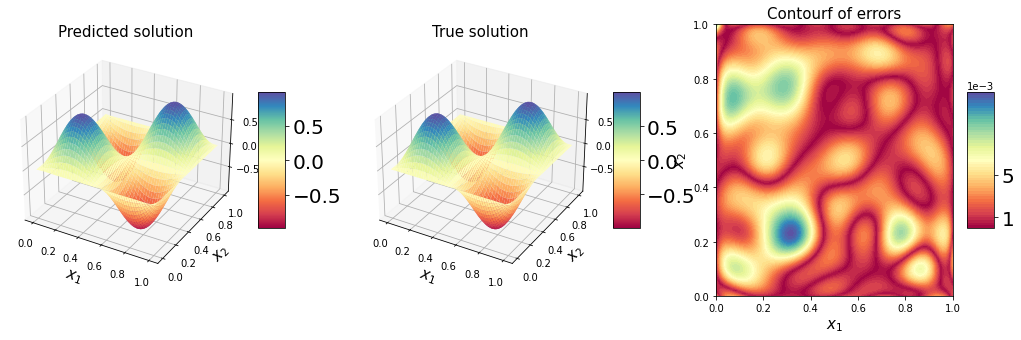

In [100]:
################### Visualization
fig = plt.figure(figsize=(18,5))

# plot the true solution
ax = fig.add_subplot(132, projection='3d')
u_truth_surf=ax.plot_surface(XX, YY, u_test, cmap='Spectral')
plt.xlabel(r'$x_1$', size=15) 
plt.ylabel(r'$x_2$', size=15)
plt.title('True solution', size=15)
cbar = fig.colorbar(u_truth_surf, shrink= 0.5, aspect = 5)
cbar.ax.tick_params(labelsize=20)

# plot the predicted solution
ax = fig.add_subplot(131, projection='3d')
u_test_surf=ax.plot_surface(XX, YY, RF_pred, cmap='Spectral')
plt.xlabel(r'$x_1$', size=15) 
plt.ylabel(r'$x_2$', size=15)
plt.title('Predicted solution', size=15)
cbar = fig.colorbar(u_test_surf, shrink= 0.5, aspect = 5)
cbar.ax.tick_params(labelsize=20)

# plot error
ax = fig.add_subplot(133)
u_contourf=ax.contourf(XX, YY, abs(u_test-RF_pred), 50, cmap='Spectral')
plt.xlabel(r'$x_1$', fontsize=15); 
plt.ylabel(r'$x_2$', fontsize=15); 
plt.title('Contourf of errors',size=15)
cbar = fig.colorbar(u_contourf, shrink= 0.5, aspect = 5, ticks=[0.001, 0.005])
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.tick_params(labelsize=20)
plt.savefig('Allen-Cahn_1.pdf', bbox_inches = 'tight')

In [101]:
############### PINN
# initialize model and optimizer
model_PINN = Allen_PINN()
optimizer = optim.Adam(model_PINN.parameters(), lr=1e-2)

# Train the model
start = time.time()
losses = train(model_PINN, optimizer, x_int_train,y_int_train, x_bound_train, y_bound_train, f, g, a, epochs=1000)
end = time.time()
print(f'Computational time is {end-start:.2f}')

# compute predictions and test error
PINN_pred = model_PINN(XX_test, YY_test)
PINN_pred = PINN_pred.detach().numpy()
PINN_pred = PINN_pred.reshape(num_pts,num_pts)
PINN_err = np.sum( (u_test.detach().numpy() - PINN_pred)**2 ) / np.size(PINN_pred)
print(f'Test error of PINN is {PINN_err:.2e}')

Epoch 0, Loss: 8462.870144974806
Epoch 500, Loss: 1593.1240348663853
Computational time is 21.31
Test error of PINN is 2.45e-01


In [102]:
################### ELM
# initialize ELM model and optimizer
model_ELM = Allen_ELM(2, N, R = 0.05)
optimizer = optim.Adam(model_ELM.parameters(), lr=1e-2)


# Train the model
start = time.time()
losses = train(model_ELM, optimizer,x_int_train,y_int_train, x_bound_train, y_bound_train,f, g, a, epochs=1000)
end = time.time()
print(f'Computational time is {end-start:.2f} seconds')

# compute predictions and test error
ELM_pred = model_ELM(XX_test, YY_test)
ELM_pred = ELM_pred.detach().numpy()
ELM_pred = ELM_pred.reshape(num_pts,num_pts)
ELM_err = np.sum( (u_test.detach().numpy() - ELM_pred)**2 ) / np.size(ELM_pred)
print(f'Test error of ELM is {ELM_err:.2e}')

Epoch 0, Loss: 4298.506032157948
Epoch 500, Loss: 1592.7720924207565
Computational time is 17.40 seconds
Test error of ELM is 2.45e-01


## Case 3: a=20

In [94]:
# 
a = 20
# generate training samples
N_pts = 30
x_int_train, y_int_train, x_bound_train, y_bound_train = sample_points(N_pts)

# generate test samples
num_pts = 100
xx= np.linspace(0, 1, num_pts)
yy = np.linspace(0, 1, num_pts)
XX, YY = np.meshgrid(xx, yy)
XX_test, YY_test = XX.reshape(num_pts**2,1), YY.reshape(num_pts**2,1)
XX_test, YY_test = torch.from_numpy(XX_test), torch.from_numpy(YY_test)
XX, YY = torch.from_numpy(XX), torch.from_numpy(YY)
u_test = u_true(a,XX,YY)

############### Random feature
# initialize model and optimizer
N = 400
model_RF = Allen_RF(2, N, sigma = 0.001)
optimizer = optim.Adam(model_RF.parameters(), lr=1e-2)

# Train the model
start =time.time()
losses = train(model_RF, optimizer, x_int_train,y_int_train, x_bound_train, y_bound_train, f, g, a, epochs=100)
end = time.time()
print(f'Computational time is {end-start:.2f}')

# compute test errors
RF_pred = model_RF(XX_test, YY_test)
RF_pred = RF_pred.detach().numpy()
RF_pred = RF_pred.reshape(num_pts,num_pts)
RF_err = np.sum( (u_test.detach().numpy() - RF_pred)**2 ) / np.size(RF_pred)
print(f'Test error of RF is {RF_err:.2e}')

Epoch 0, Loss: 6243281230.095285
Computational time is 3.72
Test error of RF is 2.49e-01


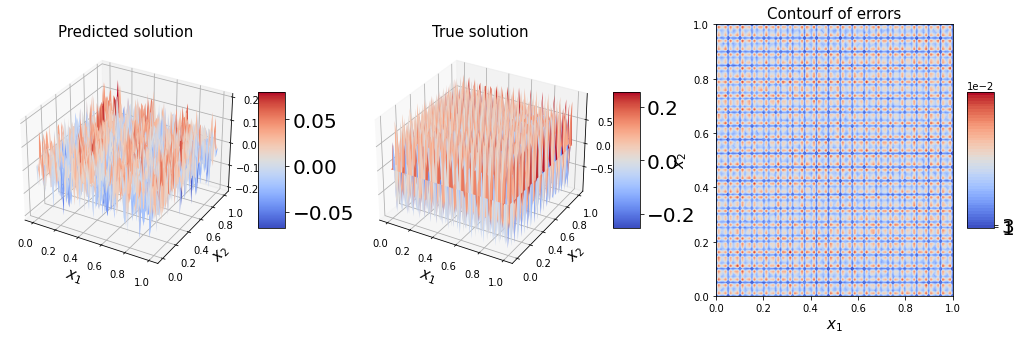

In [96]:
################### Visualization
fig = plt.figure(figsize=(18,5))

# plot the true solution
ax = fig.add_subplot(132, projection='3d')
u_truth_surf=ax.plot_surface(XX, YY, u_test, cmap=plt.cm.coolwarm)
plt.xlabel(r'$x_1$', size=15) 
plt.ylabel(r'$x_2$', size=15)
plt.title('True solution', size=15)
cbar = fig.colorbar(u_truth_surf, shrink= 0.5, aspect = 5)
cbar.ax.tick_params(labelsize=20)

# plot the predicted solution
ax = fig.add_subplot(131, projection='3d')
u_test_surf=ax.plot_surface(XX, YY, RF_pred, cmap=plt.cm.coolwarm)
plt.xlabel(r'$x_1$', size=15) 
plt.ylabel(r'$x_2$', size=15)
plt.title('Predicted solution', size=15)
cbar = fig.colorbar(u_test_surf, shrink= 0.5, aspect = 5)
cbar.ax.tick_params(labelsize=20)

# plot error
ax = fig.add_subplot(133)
u_contourf=ax.contourf(XX, YY, abs(u_test-RF_pred), 50, cmap=plt.cm.coolwarm)
plt.xlabel(r'$x_1$', fontsize=15); 
plt.ylabel(r'$x_2$', fontsize=15); 
plt.title('Contourf of errors',size=15)
cbar = fig.colorbar(u_contourf, shrink= 0.5, aspect = 5, ticks=[0.01,0.03])
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.tick_params(labelsize=20)
plt.savefig('Allen-Cahn_20.pdf', bbox_inches = 'tight')

In [63]:
############### PINN
# initialize model and optimizer
model_PINN = Allen_PINN()
optimizer = optim.Adam(model_PINN.parameters(), lr=1e-2)

# Train the model
start = time.time()
losses = train(model_PINN, optimizer, x_int_train,y_int_train, x_bound_train, y_bound_train, f, g, a, epochs=2000)
end = time.time()
print(f'Computational time is {end-start:.2f}')

# compute predictions and test error
PINN_pred = model_PINN(XX_test, YY_test)
PINN_pred = PINN_pred.detach().numpy()
PINN_pred = PINN_pred.reshape(num_pts,num_pts)
PINN_err = np.sum( (u_test.detach().numpy() - PINN_pred)**2 ) / np.size(PINN_pred)
print(f'Test error of PINN is {PINN_err:.2e}')

Epoch 0, Loss: 233282399.8517055
Epoch 500, Loss: 172283659.2818023
Epoch 1000, Loss: 135458869.3657804
Epoch 1500, Loss: 130923504.17472576
Computational time is 32.26
Test error of PINN is 6.60e+01


In [64]:
################### ELM
# initialize ELM model and optimizer
model_ELM = Allen_ELM(2, N, R = 0.05)
optimizer = optim.Adam(model_ELM.parameters(), lr=1e-2)


# Train the model
start = time.time()
losses = train(model_ELM, optimizer,x_int_train,y_int_train, x_bound_train, y_bound_train,f, g, a, epochs=1000)
end = time.time()
print(f'Computational time is {end-start:.2f} seconds')

# compute predictions and test error
ELM_pred = model_ELM(XX_test, YY_test)
ELM_pred = ELM_pred.detach().numpy()
ELM_pred = ELM_pred.reshape(num_pts,num_pts)
ELM_err = np.sum( (u_test.detach().numpy() - ELM_pred)**2 ) / np.size(ELM_pred)
print(f'Test error of ELM is {ELM_err:.2e}')

Epoch 0, Loss: 233280895.94399258
Epoch 500, Loss: 233280419.83189556
Computational time is 24.93 seconds
Test error of ELM is 2.45e-01


# Rate -- number of collocation points

In [8]:
# 
a = 1
# generate training samples
Points = [20,30,40]
T = 10
test_error = np.zeros((len(Points),T))

# generate test samples
num_pts = 100
xx= np.linspace(0, 1, num_pts)
yy = np.linspace(0, 1, num_pts)
XX, YY = np.meshgrid(xx, yy)
XX_test, YY_test = XX.reshape(num_pts**2,1), YY.reshape(num_pts**2,1)
XX_test, YY_test = torch.from_numpy(XX_test), torch.from_numpy(YY_test)
XX, YY = torch.from_numpy(XX), torch.from_numpy(YY)
u_test = u_true(a,XX,YY)

############### Random feature
# initialize model and optimizer
N = 100
epochs = [600,600,800]

for i in range(len(Points)):
    
    N_pts = Points[i]
    
    for j in range(T):
    
        # generate training samples
        x_int_train, y_int_train, x_bound_train, y_bound_train = sample_points(N_pts)
    
        # random feature model
        model_RF = Allen_RF(2, N, sigma = 0.1)
        optimizer = optim.Adam(model_RF.parameters(), lr=1e-2)

        # Train the model
        losses = train(model_RF, optimizer, x_int_train,y_int_train, x_bound_train, y_bound_train, f, g, a, epochs=epochs[i])

        # compute test errors
        RF_pred = model_RF(XX_test, YY_test)
        RF_pred = RF_pred.detach().numpy()
        RF_pred = RF_pred.reshape(num_pts,num_pts)
        RF_err = np.sum( (u_test.detach().numpy() - RF_pred)**2 ) / np.size(RF_pred)
        test_error[i,j] = RF_err

Epoch 0, Loss: 14815.590095691136
Epoch 0, Loss: 5032.12284394868
Epoch 0, Loss: 11579.834317140936
Epoch 0, Loss: 10415.41512402543
Epoch 0, Loss: 6784.352261057927
Epoch 0, Loss: 3591.7756932922366
Epoch 0, Loss: 20384.02175048768
Epoch 0, Loss: 5101.681119510289
Epoch 0, Loss: 11558.720263099367
Epoch 0, Loss: 19426.74739934564
Epoch 0, Loss: 8181.168602036032
Epoch 0, Loss: 5601.768792721105
Epoch 0, Loss: 7824.188508371022
Epoch 0, Loss: 7113.0304233499355
Epoch 0, Loss: 5161.143768321498
Epoch 0, Loss: 14767.658035523687
Epoch 0, Loss: 5811.3580982251915
Epoch 0, Loss: 4198.769653930937
Epoch 0, Loss: 6256.5810954653625
Epoch 0, Loss: 5677.963248948451
Epoch 0, Loss: 6851.923665761251
Epoch 0, Loss: 4939.240670474325
Epoch 0, Loss: 12694.711300728135
Epoch 0, Loss: 9110.109427860654
Epoch 0, Loss: 10869.437744088058
Epoch 0, Loss: 15381.68465463747
Epoch 0, Loss: 5931.6687170898
Epoch 0, Loss: 9363.078119545466
Epoch 0, Loss: 5320.053379065837
Epoch 0, Loss: 5074.110994075547


-0.7942166664488297


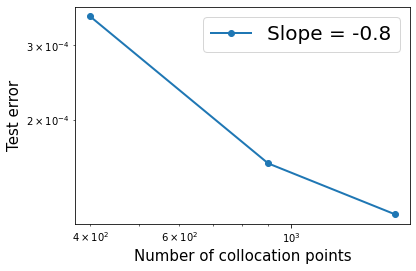

In [9]:
# compute slope
k = np.polyfit(np.log(Points), np.log(np.mean(test_error,axis=1)), deg=1)[0]/2
print(k)

# visualization
plt.loglog(np.power(Points,2), np.mean(test_error,axis=1), '-o', label=f'Slope = {k:.1f}', linewidth=2)
plt.legend(fontsize=20)
plt.xlabel('Number of collocation points', size=15)
plt.ylabel('Test error',size=15)
plt.savefig('Allen_m.pdf', bbox_inches = 'tight')

# Rate --  number of random features

In [21]:
N_pts = 20

N_range = [100,200,400]

T = 3
test_error = np.zeros((len(N_range),T))

# generate test samples
num_pts = 100
xx= np.linspace(0, 1, num_pts)
yy = np.linspace(0, 1, num_pts)
XX, YY = np.meshgrid(xx, yy)
XX_test, YY_test = XX.reshape(num_pts**2,1), YY.reshape(num_pts**2,1)
XX_test, YY_test = torch.from_numpy(XX_test), torch.from_numpy(YY_test)
XX, YY = torch.from_numpy(XX), torch.from_numpy(YY)
u_test = u_true(a,XX,YY)

for i in range(len(N_range)):
    
    N = N_range[i]
    x_int_train, y_int_train, x_bound_train, y_bound_train = sample_points(N_pts)
    
    for j in range(T):
    
        # initialize model and optimizer
        model_RF = Allen_RF(2, N, sigma = 0.1)
        optimizer = optim.Adam(model_RF.parameters(), lr=1e-2)

        # Train the model
        losses = train(model_RF, optimizer, x_int_train,y_int_train, x_bound_train, y_bound_train, f, g, a, epochs=1000)
        
        # compute test errors
        RF_pred = model_RF(XX_test, YY_test)
        RF_pred = RF_pred.detach().numpy()
        RF_pred = RF_pred.reshape(num_pts,num_pts)
        RF_err = np.sum( (u_test.detach().numpy() - RF_pred)**2 ) / np.size(RF_pred)
        test_error[i,j] = RF_err

Epoch 0, Loss: 5519.935174663939
Epoch 0, Loss: 4635.821844587545
Epoch 0, Loss: 5532.3995360487825
Epoch 0, Loss: 3476.3015002725306
Epoch 0, Loss: 4946.089051109074
Epoch 0, Loss: 3818.554861922551
Epoch 0, Loss: 3430.4229894274813
Epoch 0, Loss: 4665.612421660237
Epoch 0, Loss: 2139.6133909479213


-1.7356212506712234


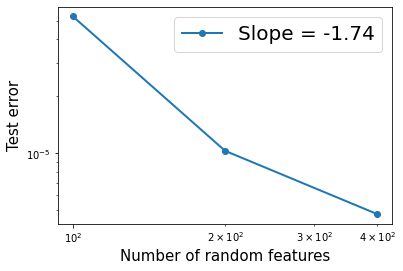

In [22]:
# compute slope
k = np.polyfit(np.log(N_range), np.log(np.mean(test_error,axis=1)), deg=1)[0]
print(k)

# visualization
plt.loglog(N_range, np.mean(test_error,axis=1), '-o', label=f'Slope = {k:.2f}', linewidth=2)
plt.legend(fontsize=20)
plt.xlabel('Number of random features', size=15)
plt.ylabel('Test error', size=15)
plt.savefig('Allen_N.pdf', bbox_inches = 'tight')